In [ ]:
!nvidia-smi

Tue Sep 22 02:17:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* @file NLP進階 / RNN_stock_prediction
  * @brief RNN_stock_prediction 模型實作 

  * 此份程式碼是以教學為目的，附有完整的架構解說。

  * @author 人工智慧科技基金會 AI 工程師 - 康文瑋
  * Email: run963741@aif.tw
  * Resume: https://www.cakeresume.com/run963741

  * 最後更新日期: 2020/11/13

# 載入函數

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

os.chdir('/content/drive/Shared drives/類技術班教材/標準版/RNN 遞歸神經網路')

# 載入資料集

[Tesla, Inc. Common Stock (TSLA)
](https://www.nasdaq.com/market-activity/stocks/tsla/historical)

我們使用的資料集是來自於 Nasdaq 官網上的特斯拉股價，時間從 2010/09/20 至 2020/09/18，特徵包含了日期 (Date)、收盤價 (Close/Last)、成交量 (Volume)、開盤價 (Open)、當日最高點 (High)、當日最低點 (Low)。

我們的預測目標就是使用前 N 天的特徵 (收盤價,成交量,開盤價,當日最高點, 當日最低點) 來預測第 N+1 天的收盤價。

In [ ]:
tesla_stocks = pd.read_csv('Data/HistoricalQuotes.csv')

In [ ]:
# 資料共有六個資訊，日期、收盤、成交量、開盤、當日最高、當日最低
tesla_stocks.head()

,Date,Close/Last,Volume,Open,High,Low
0,09/18/2020,$442.15,86406820,$447.94,$451,$428.8
1,09/17/2020,$423.43,76779160,$415.6,$437.79,$408.0001
2,09/16/2020,$441.76,72546760,$439.87,$457.79,$435.31
3,09/15/2020,$449.76,97298230,$436.56,$461.94,$430.7
4,09/14/2020,$419.62,83020610,$380.95,$420,$373.3


In [ ]:
tesla_stocks.tail()

,Date,Close/Last,Volume,Open,High,Low
2513,09/24/2010,$4.02,2894435,$3.99,$4.038,$3.93
2514,09/23/2010,$3.912,3340380,$3.978,$4.028,$3.9
2515,09/22/2010,$3.974,4814080,$4.174,$4.19,$3.96
2516,09/21/2010,$4.154,3980000,$4.178,$4.31,$4.134
2517,09/20/2010,$4.211,4737375,$4.134,$4.27,$4.032


# 資料前處理

1. 將前綴 $ 去除
2. 轉換日期格式，由小排到大

In [ ]:
for col in tesla_stocks.columns[1:]:
  tesla_stocks[col] = tesla_stocks[col].astype(str).str.replace('$', '').astype(float)

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
tesla_stocks = tesla_stocks.sort_values(by='Date', ascending=True)

In [ ]:
tesla_stocks.head()

,Date,Close/Last,Volume,Open,High,Low
2517,2010-09-20,4.211,4737375.0,4.134,4.270,4.032
2516,2010-09-21,4.154,3980000.0,4.178,4.310,4.134
2515,2010-09-22,3.974,4814080.0,4.174,4.190,3.960
2514,2010-09-23,3.912,3340380.0,3.978,4.028,3.900
2513,2010-09-24,4.020,2894435.0,3.990,4.038,3.930


## 過濾日期

使用 2010-09-20 至 2020-01-01 的股價

In [ ]:
end_date = '2020-01-01'
mask = tesla_stocks['Date'] <= end_date
tesla_stocks = tesla_stocks.loc[mask]

tesla_stocks.head()

,Date,Close/Last,Volume,Open,High,Low
2517,2010-09-20,4.211,4737375.0,4.134,4.270,4.032
2516,2010-09-21,4.154,3980000.0,4.178,4.310,4.134
2515,2010-09-22,3.974,4814080.0,4.174,4.190,3.960
2514,2010-09-23,3.912,3340380.0,3.978,4.028,3.900
2513,2010-09-24,4.020,2894435.0,3.990,4.038,3.930


畫圖觀察每個特徵的趨勢變化

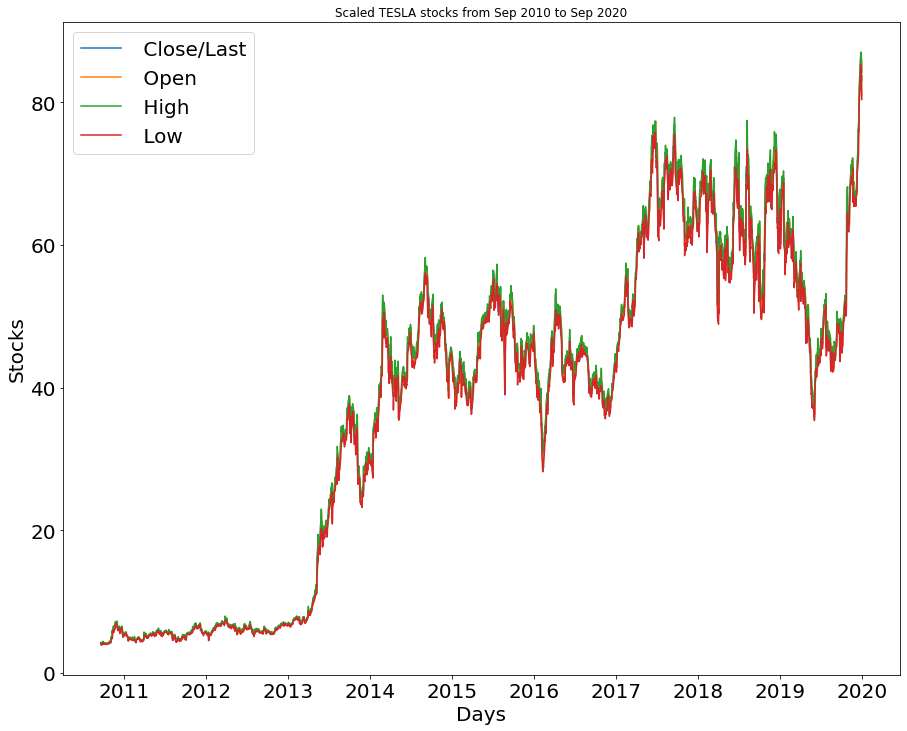

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(15, 12), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from Sep 2010 to Sep 2020')
plt.xlabel('Days', fontsize=20)
plt.ylabel('Stocks', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for col in [' Close/Last', ' Open', ' High', ' Low']:
  plt.plot(tesla_stocks.Date, tesla_stocks[col], label=col)
plt.legend(fontsize=20)
plt.show()

## 標準化

這邊將四個特徵做標準化 (Normalization)，目的是為了穩定訓練過程，讓 RNN 模型盡量不發生梯度消失 (Gradient vanishing) 以及梯度爆炸 (Exploding gradient) 的現象。

In [ ]:
# 使用sklearn套件將資料標準化(mean = 0, std = 1)
scaler = StandardScaler()

In [ ]:
scaled_dataset = scaler.fit_transform(tesla_stocks.iloc[:,1:])

In [ ]:
scaled_dataset

array([[-1.47041595, -0.96845456, -1.47410582, -1.47400419, -1.47245614],
       [-1.47293926, -1.00067175, -1.4721572 , -1.47225953, -1.46786485],
       [-1.48090761, -0.96519168, -1.47233435, -1.47749351, -1.47569706],
       ...,
       [ 2.15363387,  0.94774323,  2.19575704,  2.13709704,  2.18212444],
       [ 2.0148075 ,  1.51018943,  2.14075294,  2.08205295,  2.03042266],
       [ 2.04694652,  1.01912896,  1.93003675,  2.01479624,  1.96579344]])

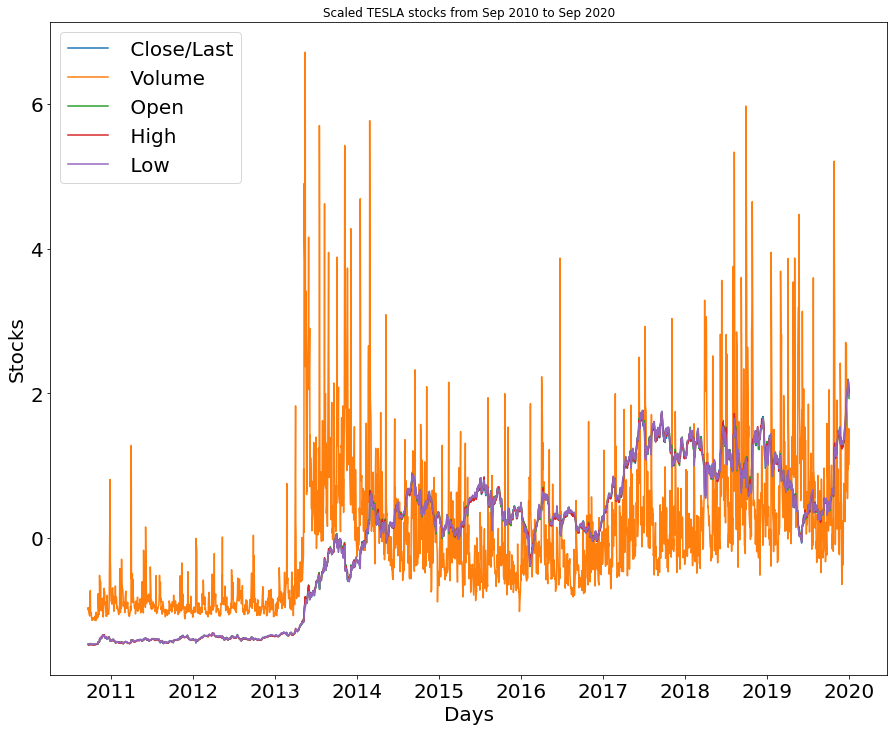

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(15, 12), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from Sep 2010 to Sep 2020')
plt.xlabel('Days', fontsize=20)
plt.ylabel('Stocks', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i, col in enumerate(tesla_stocks.columns[1:]):
  plt.plot(tesla_stocks.Date, scaled_dataset[:,i], label=col)
plt.legend(fontsize=20)
plt.show()

##  使用 sliding window 產生資料

訓練的方式是使用前 N 天的資料預測第 N+1 天的收盤價，這邊定義一個 window_data(data, window_size) 函數，將資料處理成 sliding window 的格式。

In [ ]:
# 抓取window_size的資料作為觀察資料(x), 下一天作為預測資料(y)

def window_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= data.shape[0] - 1:
        X.append(data[i:i+window_size,:])
        y.append(data[i+window_size,0])
        i += 1
    X = np.array(X)
    y = np.array(y)
    assert len(X) == len(y)
    return X, y

假設 window_size 設為 12，也就是使用 12 天的資料來預測 第 13 天的收盤價。

In [ ]:
window_size = 12
X, y = window_data(scaled_dataset, window_size)

In [ ]:
print_index = 0
print('前 %d 天特徵: \n' % window_size, X[print_index])
print('第 %d 天收盤價: ' % (window_size + 1), y[print_index])

前 12 天特徵: 
 [[-1.47041595 -0.96845456 -1.47410582 -1.47400419 -1.47245614]
 [-1.47293926 -1.00067175 -1.4721572  -1.47225953 -1.46786485]
 [-1.48090761 -0.96519168 -1.47233435 -1.47749351 -1.47569706]
 [-1.48365226 -1.02787989 -1.48101455 -1.48455939 -1.47839782]
 [-1.47887125 -1.04684949 -1.48048311 -1.48412323 -1.47704744]
 [-1.47506415 -1.08143073 -1.4764973  -1.47871477 -1.47344642]
 [-1.46736141 -0.91166849 -1.4708286  -1.47278292 -1.46705462]
 [-1.46222625 -0.75116592 -1.4695     -1.46807234 -1.46372368]
 [-1.47617087 -0.72810183 -1.46232555 -1.46702554 -1.47218607]
 [-1.47444439 -1.0428607  -1.47392867 -1.47923817 -1.47110576]
 [-1.47099144 -1.0330859  -1.47623158 -1.47557438 -1.47119579]
 [-1.46984046 -1.09937346 -1.4698543  -1.47461482 -1.46480398]]
第 13 天收盤價:  -1.475683912565607


## 訓練集 (Train) 與測試集 (Test) 切割

In [ ]:
train_size = 2000

X_train = np.array(X[:train_size])
y_train = np.array(y[:train_size])

X_test = np.array(X[train_size:])
y_test = np.array(y[train_size:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (2000, 12, 5)
y_train size: (2000,)
X_test size: (325, 12, 5)
y_test size: (325,)


# 建立模型

我們使用 tensorflow 來建立 RNN 模型。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1uYwxqikk1bXmj7tdqSe3Ca4SwTuTe-PN' width="700"/>
<figcaption>Recurrent Neural Network</figcaption></center>
</figure>

$$
h_t=RNN(x_t,h_{t-1})
$$

tensorflow 提供三種建立模型的方法：

1. Sequential API
2. Functional API
3. Model Subclassing

以下為 Model Subclassing 的寫法。

In [ ]:
class stock_rnn(tf.keras.Model):
  def __init__(self, rnn_units, output_units):
    super().__init__()
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units, recurrent_initializer='glorot_uniform', return_sequences=True)
    self.output_layer = tf.keras.layers.Dense(units=output_units)

  def call(self, x):
    hidden_states = self.rnn(x)
    last_state = hidden_states[:,-1,:]
    output = self.output_layer(last_state)

    return output

  def _model(self):
        x = tf.keras.layers.Input(shape=(window_size, 5))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [ ]:
rnn_units = 36
output_units = 1

stock_rnn(rnn_units, output_units)._model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 5)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 12, 36)            1512      
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 36)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 37        
Total params: 1,549
Trainable params: 1,549
Non-trainable params: 0
_________________________________________________________________


# 編譯模型

In [ ]:
rnn_units = 36
output_units = 1

model = stock_rnn(rnn_units, output_units)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='mse', optimizer=optimizer)

# 訓練模型

In [ ]:
model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), batch_size=128)

Epoch 1/300
16/16 [==============================] - 0s 17ms/step - loss: 0.1359 - val_loss: 0.1260
Epoch 2/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0516 - val_loss: 0.0737
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0281 - val_loss: 0.0433
Epoch 4/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0169 - val_loss: 0.0306
Epoch 5/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0125 - val_loss: 0.0265
Epoch 6/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0241
Epoch 7/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.0222
Epoch 8/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0211
Epoch 9/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0199
Epoch 10/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0188
Epoch 11

# 模型評估

In [ ]:
# Training set預測結果
training_set_pred = model.predict(X_train)

# Testing set預測結果
testing_set_pred = model.predict(X_test)

In [ ]:
# training = [0]*window_size + [t[0] for t in training_set_pred] + [0]*len(X_test)
# testing = [0] * (window_size + len(X_train)) + [t[0] for t in testing_set_pred]


training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i][0])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i][0])
    training.append(None)
    testing_loss += (testing_set_pred[i][0] - y_test[i])**2
print('testing_loss:', testing_loss / len(X_test))

testing_loss: 0.00909151105725021


# 視覺化預測結果

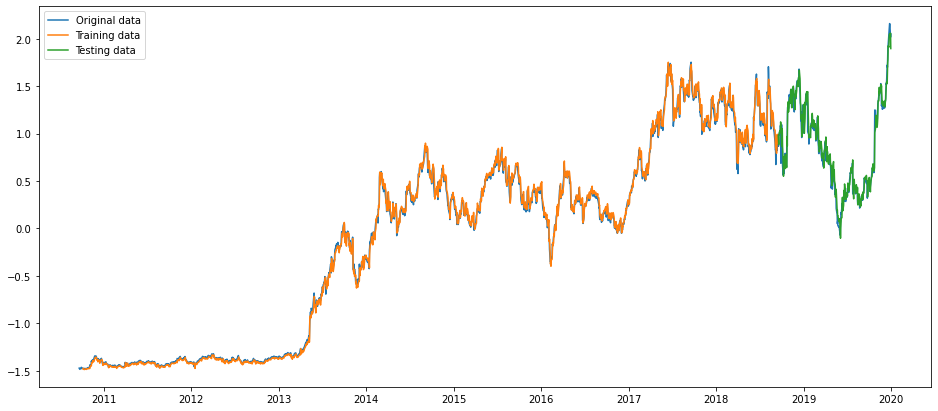

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset[:,0], label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()